In [5]:
%pip install pandas numpy matplotlib scikit-learn tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.8 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 200.4 MB 5.5 MB/s eta 0:00:011     |███████████████████████████     | 169.4 MB 17.5 MB/s eta 0:00:02
     |████████████████████████████████| 348 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 9.7 MB/s eta 0:00:01
     |█████████████████████

/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_30166/2690607166.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f"{int(txt)}", (months[i], forecast_2025[i] + 300), ha='center', fontweight='bold', color='green')


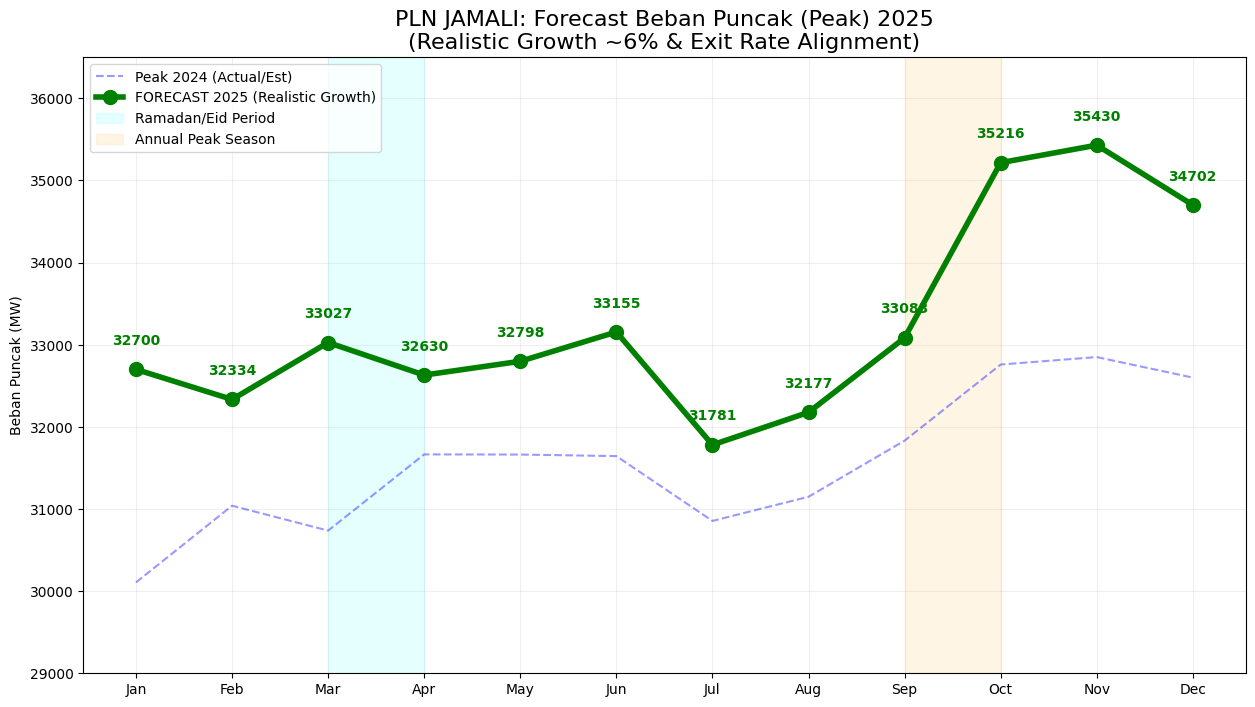

--- PROYEKSI BEBAN PUNCAK 2025 (REVISED) ---
Jan    32700
Feb    32334
Mar    33027
Apr    32630
May    32798
Jun    33155
Jul    31781
Aug    32177
Sep    33083
Oct    35216
Nov    35430
Dec    34702
dtype: int64


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import calendar

# 1. Data Historis Lengkap (Jan-Okt 2024 Aktual, Nov-Des 2024 Estimasi Realistis)
data_peak = {
    '2022': [28061, 27524, 28334, 29042, 28823, 28399, 28522, 28689, 29026, 28234, 28314, 28600],
    '2023': [28673, 27890, 29051, 29316, 29390, 29689, 28967, 29313, 29975, 31082, 31518, 30906],
    # 2024 disesuaikan agar akhir tahun tetap stabil tinggi di kisaran 32.7 GW
    '2024': [30107, 31040, 30737, 31665, 31663, 31644, 30855, 31149, 31832, 32759, 32850, 32600]
}
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df = pd.DataFrame(data_peak, index=months)

# --- PROSES PERAMALAN 2025 (REVISED MODEL) ---

# Menggunakan pertumbuhan tahunan rata-rata (~6%) sebagai jangkar agar tidak overshooting
growth_anchor = 1.06 

forecast_2025_list = []
for m in months:
    y = df.loc[m].values
    X = np.array([2022, 2023, 2024]).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Prediksi Regresi Linear
    pred_raw = model.predict([[2025]])[0]
    
    # Balancing: Membatasi agar growth tiap bulan tidak meledak melampaui anchor
    # Ini mencegah angka 37.000 MW yang tidak realistis
    max_allowed = df.loc[m, '2024'] * 1.08 # Maksimal tumbuh 8% per bulan
    min_allowed = df.loc[m, '2024'] * 1.03 # Minimal tumbuh 3% per bulan
    
    pred_final = np.clip(pred_raw, min_allowed, max_allowed)
    forecast_2025_list.append(pred_final)

forecast_2025 = pd.Series(forecast_2025_list, index=months)

# --- PENYESUAIAN KHUSUS 2025 (LEBARAN 31 MARET) ---
# Januari 2025 disetel agar dekat dengan Oktober 2024 (Sesuai masukan mentor)
forecast_2025['Jan'] = max(forecast_2025['Jan'], 32700)

# Maret (Ramadan) & April (Lebaran)
# Lebaran di akhir Maret membuat Maret sedikit turun di akhir, tapi April tetap punya hari kerja produktif
forecast_2025['Mar'] = forecast_2025['Jan'] * 1.01 # Konsumsi stabil Ramadan
# April 2025: Meskipun Lebaran, Peak MW tidak jatuh dalam (belajar dari 2024)
forecast_2025['Apr'] = max(forecast_2025['Apr'], forecast_2025['Mar'] * 0.98) 

# --- VISUALISASI ---
plt.figure(figsize=(15, 8))
plt.plot(months, df['2024'], label='Peak 2024 (Actual/Est)', color='blue', alpha=0.4, linestyle='--')
plt.plot(months, forecast_2025, label='FORECAST 2025 (Realistic Growth)', color='green', linewidth=4, marker='o', markersize=10)

# Highlight Area Musim Panas & Ramadan
plt.axvspan('Mar', 'Apr', color='cyan', alpha=0.1, label='Ramadan/Eid Period')
plt.axvspan('Sep', 'Oct', color='orange', alpha=0.1, label='Annual Peak Season')

# Label Angka
for i, txt in enumerate(forecast_2025):
    plt.annotate(f"{int(txt)}", (months[i], forecast_2025[i] + 300), ha='center', fontweight='bold', color='green')

plt.title('PLN JAMALI: Forecast Beban Puncak (Peak) 2025\n(Realistic Growth ~6% & Exit Rate Alignment)', fontsize=16)
plt.ylabel('Beban Puncak (MW)')
plt.grid(True, alpha=0.2)
plt.legend(loc='upper left')
plt.ylim(29000, 36500)
plt.show()

print("--- PROYEKSI BEBAN PUNCAK 2025 (REVISED) ---")
print(forecast_2025.astype(int))

/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_1774/3151514807.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_1774/3151514807.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f"{int(forecast_oct_2025[i])}",
/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_1774/3151514807.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

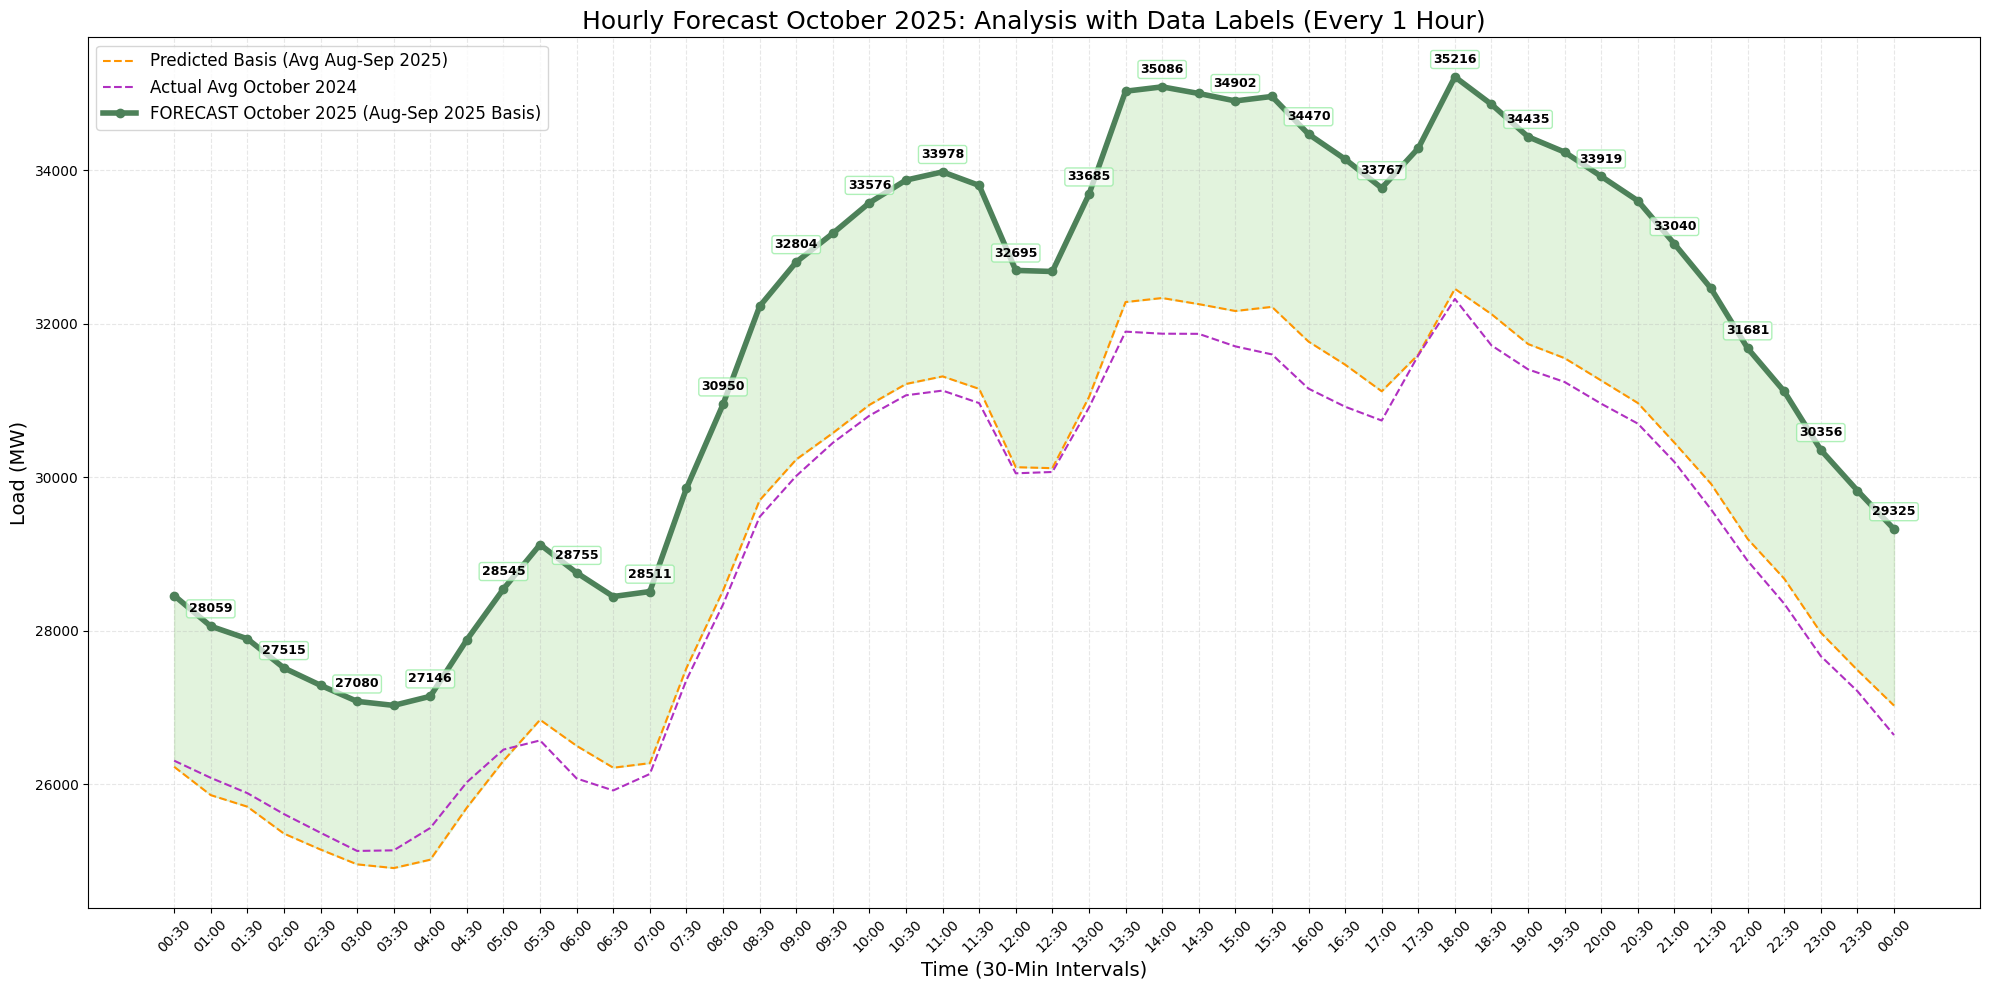

Beban Puncak Basis (Prediksi Agt-Sep 2025): 32454 MW
Target Beban Puncak (Oktober 2025): 35216 MW
Kenaikan dari Momentum ke Puncak: 8.51%


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. LOAD & CLEAN DATA
df = pd.read_csv('Load_Forecasting.csv')
time_cols = df.columns[2:50]
for col in time_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[time_cols] = df[time_cols].ffill(axis=1).bfill(axis=1)
df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True)

# 2. TAHAP 1: PREDIKSI PROFIL AGUSTUS & SEPTEMBER 2025
years = [2022, 2023, 2024]
X = np.array(years).reshape(-1, 1)

predicted_aug_sep_2025 = []

for col in time_cols:
    y_vals = []
    for yr in years:
        val = df[(df['Tanggal_dt'].dt.year == yr) & 
                 (df['Tanggal_dt'].dt.month.isin([8, 9])) & 
                 (df['Beban Sistem'] == 'Wednesday')][col].mean()
        y_vals.append(val)
    
    reg = LinearRegression().fit(X, y_vals)
    predicted_aug_sep_2025.append(reg.predict([[2025]])[0])

profile_augsep_2025 = pd.Series(predicted_aug_sep_2025, index=time_cols)

# 3. TAHAP 2: SCALING KE OKTOBER 2025
target_peak_oct_25 = 35216
scaling_factor_oct = target_peak_oct_25 / profile_augsep_2025.max()
forecast_oct_2025 = profile_augsep_2025 * scaling_factor_oct

# 4. DATA PEMBANDING (Oktober 2024 Aktual)
actual_oct_2024 = df[(df['Tanggal_dt'].dt.month == 10) & 
                     (df['Tanggal_dt'].dt.year == 2024) & 
                     (df['Beban Sistem'] == 'Wednesday')][time_cols].mean()

# 5. VISUALISASI
plt.figure(figsize=(20, 10))

# Plot Momentum 2025 (Agt-Sep)
plt.plot(time_cols, profile_augsep_2025, label='Predicted Basis (Avg Aug-Sep 2025)', 
         color="#FF9500", linestyle='--', alpha=1)

# Plot Aktual 2024
plt.plot(time_cols, actual_oct_2024, label='Actual Avg October 2024', 
         color="#B030C1", alpha=1, linestyle='--')

# Plot Final Forecast 2025 dengan Marker Bulat
plt.plot(time_cols, forecast_oct_2025, label='FORECAST October 2025 (Aug-Sep 2025 Basis)', 
         color="#4d8159", linewidth=4, marker='o', markevery=1)

# --- TAMBAHAN: DATA LABELS SETIAP 1 JAM ---
# Kita mulai dari index 1 (01:00) dan melompat setiap 2 langkah (1 jam)
for i in range(1, len(time_cols), 2):
    plt.annotate(f"{int(forecast_oct_2025[i])}", 
                 (time_cols[i], forecast_oct_2025[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=9, 
                 fontweight='bold', 
                 color="#000000",
                 bbox=dict(boxstyle='round,pad=0.2', fc='white', ec="#8deb9b", alpha=0.7))

# Dekorasi
plt.title('Hourly Forecast October 2025: Analysis with Data Labels (Every 1 Hour)', fontsize=18)
plt.ylabel('Load (MW)', fontsize=14)
plt.xlabel('Time (30-Min Intervals)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', fontsize=12)

# Arsir area pertumbuhan
plt.fill_between(time_cols, profile_augsep_2025, forecast_oct_2025, color="#72C556", alpha=0.2)

plt.tight_layout()
plt.show()

# 6. ANALISIS PERUBAHAN
print(f"Beban Puncak Basis (Prediksi Agt-Sep 2025): {int(profile_augsep_2025.max())} MW")
print(f"Target Beban Puncak (Oktober 2025): {target_peak_oct_25} MW")
print(f"Kenaikan dari Momentum ke Puncak: {((scaling_factor_oct-1)*100):.2f}%")

/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_1774/3716618376.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')


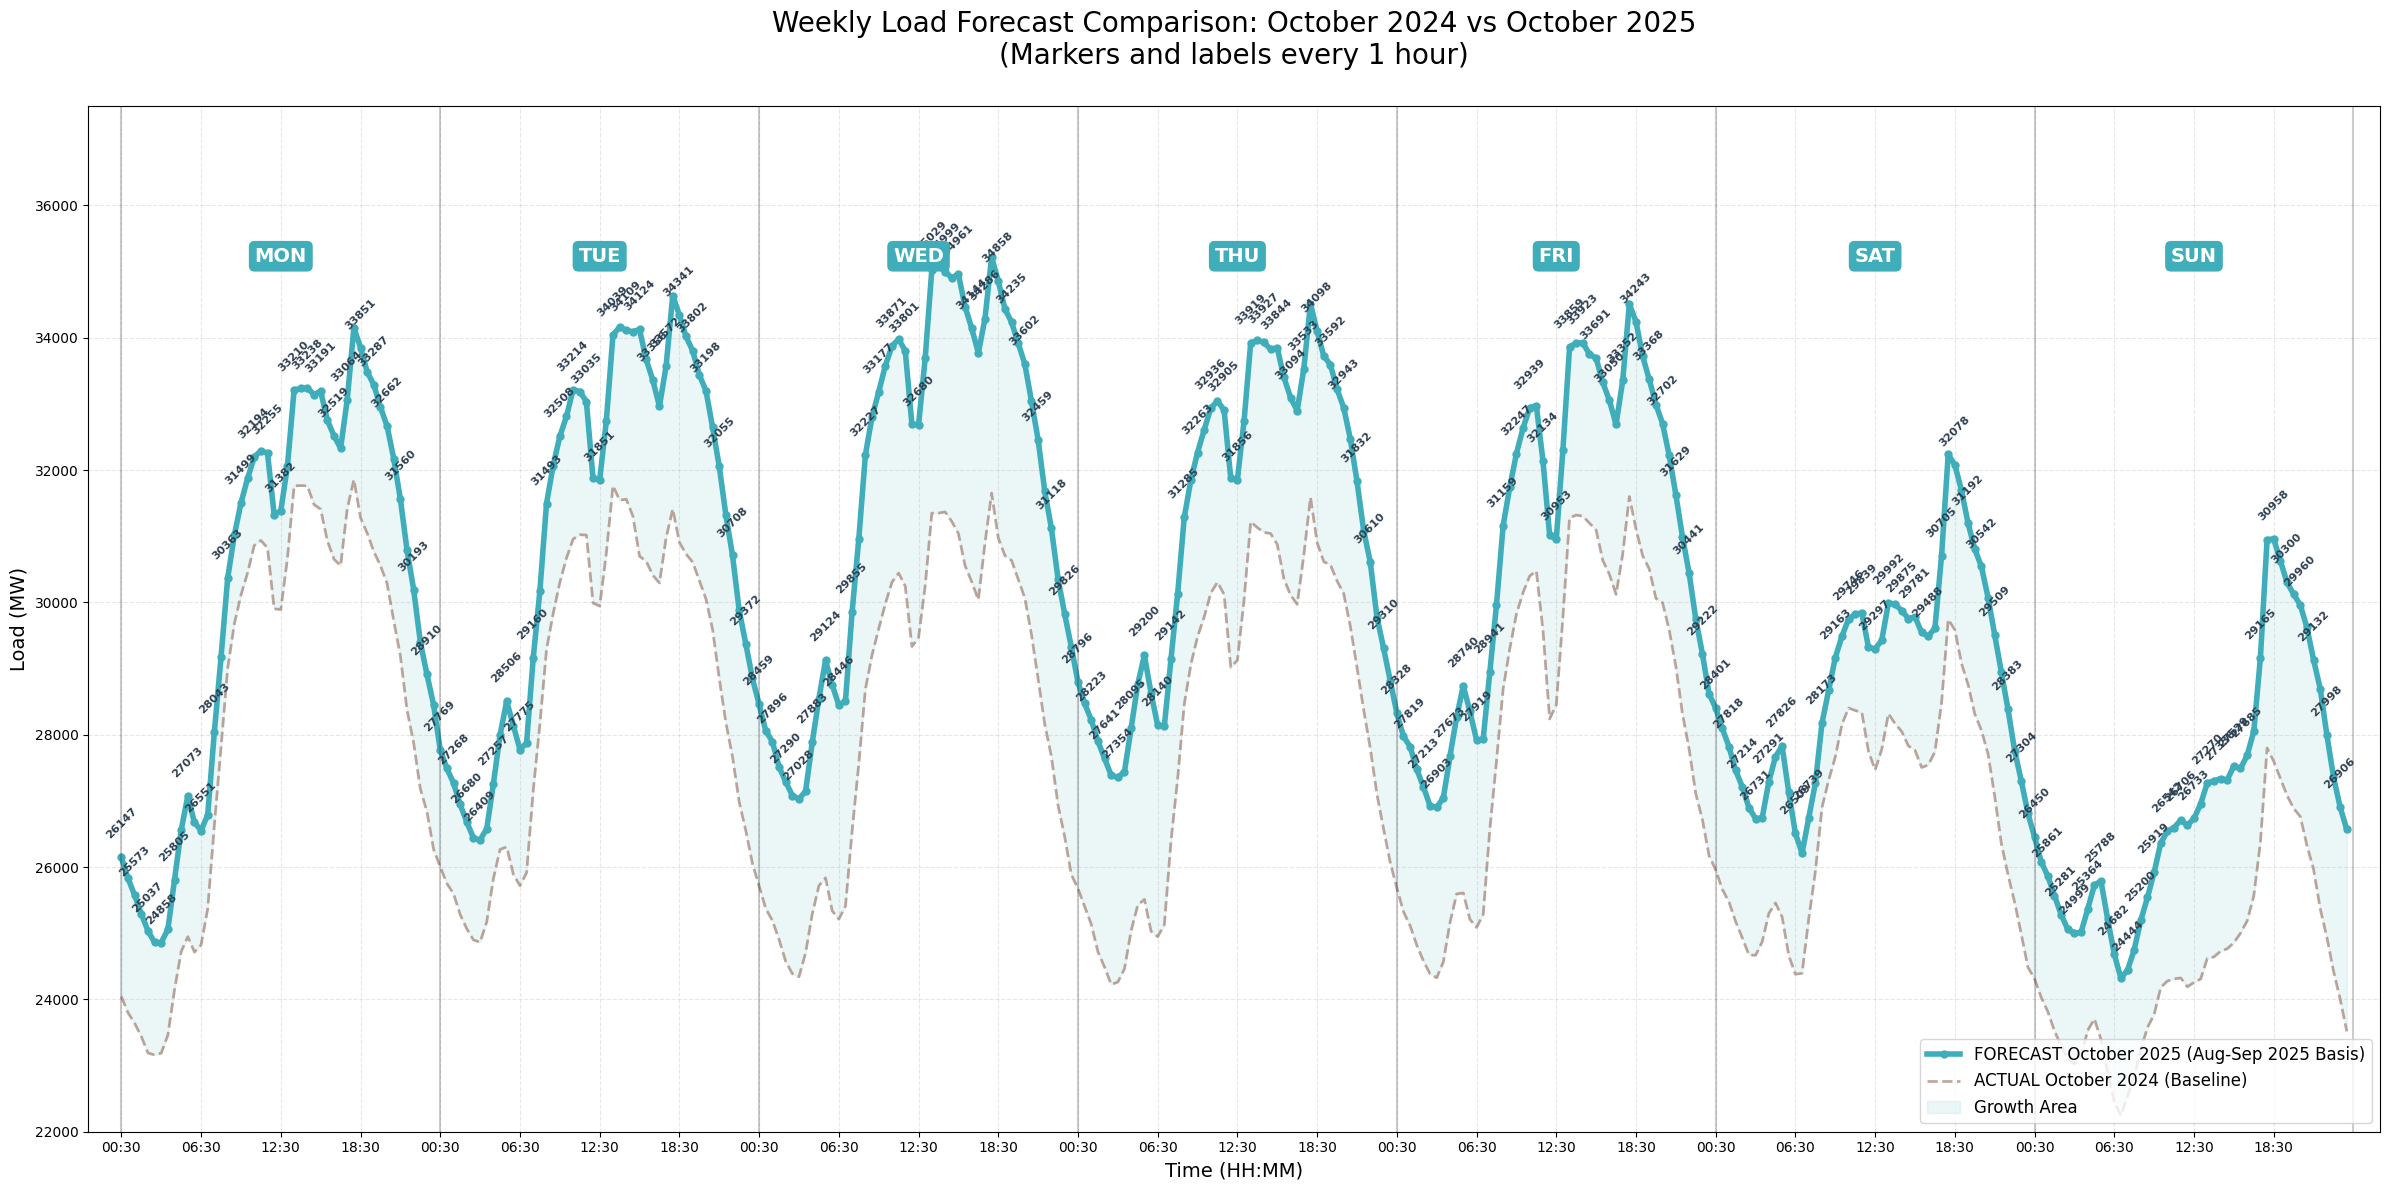

Beban Puncak 2024 (Okt): 31855 MW
Proyeksi Puncak 2025 (Okt): 35216 MW
Estimasi Kenaikan Beban: 10.55%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. LOAD & CLEAN DATA
df = pd.read_csv('Load_Forecasting.csv')
time_cols = df.columns[2:50] 

for col in time_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[time_cols] = df[time_cols].ffill(axis=1).bfill(axis=1)
df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')

# 2. TAHAP 1: PREDIKSI PROFIL AGUSTUS & SEPTEMBER 2025 (SEBAGAI BASIS)
years = np.array([2022, 2023, 2024]).reshape(-1, 1)
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
projected_profiles_2025 = {}

for day in week_days:
    hourly_values_2025 = []
    for col in time_cols:
        y = []
        for yr in [2022, 2023, 2024]:
            val = df[(df['Tanggal_dt'].dt.year == yr) & 
                     (df['Tanggal_dt'].dt.month.isin([8, 9])) & 
                     (df['Beban Sistem'] == day)][col].mean()
            y.append(val)
        model = LinearRegression().fit(years, y)
        hourly_values_2025.append(model.predict([[2025]])[0])
    projected_profiles_2025[day] = np.array(hourly_values_2025)

# 3. TAHAP 2: SCALING KE TARGET OKTOBER 2025 (35.216 MW)
target_peak_oct_25 = 35216
all_values_augsep = np.concatenate(list(projected_profiles_2025.values()))
base_max_2025 = np.max(all_values_augsep)
scaling_factor = target_peak_oct_25 / base_max_2025

# Generate deret data 1 minggu 2025
forecast_2025_series = []
for day in week_days:
    forecast_2025_series.extend(projected_profiles_2025[day] * scaling_factor)
forecast_2025_series = np.array(forecast_2025_series)

# 4. AMBIL DATA PEMBANDING (Minggu ke-3 Oktober 2024: 14-20 Okt)
start_24 = '2024-10-14'
end_24 = '2024-10-20'
actual_2024_week = df[(df['Tanggal_dt'] >= start_24) & (df['Tanggal_dt'] <= end_24)]
# Pastikan urutan hari sesuai Senin-Minggu
actual_2024_week = actual_2024_week.set_index('Beban Sistem').loc[week_days].reset_index()
actual_2024_series = actual_2024_week[time_cols].values.flatten()

# 5. PREPARASI X-AXIS (JAM)
hour_labels = list(time_cols) * 7
x_ticks_positions = np.arange(0, 336, 12) # Tampilkan label tiap 6 jam
x_ticks_labels = [hour_labels[i] for i in x_ticks_positions]

# 6. VISUALISASI
plt.figure(figsize=(24, 12))

# Plot Forecast 2025
plt.plot(forecast_2025_series, color="#3FAEBA", linewidth=4, marker='o', markersize=5, 
         label='FORECAST October 2025 (Aug-Sep 2025 Basis)')

# Plot Aktual 2024 (Sebagai Pembanding)
plt.plot(actual_2024_series, color="#996e5e", linewidth=2, linestyle='--', alpha=0.6, 
         label='ACTUAL October 2024 (Baseline)')

# Tambahkan Angka Beban di setiap 1 jam (setiap 2 interval) pada garis 2025
for i in range(0, len(forecast_2025_series), 2):
    plt.text(i, forecast_2025_series[i] + 250, f'{int(forecast_2025_series[i])}', 
             ha='center', va='bottom', fontsize=8, color='#2c3e50', rotation=45, fontweight='bold')

# Arsir area pertumbuhan (Growth Area)
plt.fill_between(range(336), actual_2024_series, forecast_2025_series, color='#3FAEBA', alpha=0.1, label='Growth Area')

# Garis bantu vertikal per hari & Label Hari
day_names = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for i in range(8):
    plt.axvline(x=i*48, color='black', linestyle='-', alpha=0.2)
    if i < 7:
        plt.text(i*48 + 24, plt.ylim()[1] * 0.98, day_names[i], 
                 ha='center', fontweight='bold', fontsize=14, color='white',
                 bbox=dict(facecolor='#3FAEBA', edgecolor='none', boxstyle='round,pad=0.3'))

# Pengaturan Axis
plt.title('Weekly Load Forecast Comparison: October 2024 vs October 2025\n(Markers and labels every 1 hour)', fontsize=20, pad=30)
plt.ylabel('Load (MW)', fontsize=14)
plt.xlabel('Time (HH:MM)', fontsize=14)
plt.xticks(x_ticks_positions, x_ticks_labels)

plt.grid(True, which='major', axis='both', linestyle='--', alpha=0.3)
plt.xlim(-5, 340)
plt.ylim(22000, 37500)
plt.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

# Output data
print(f"Beban Puncak 2024 (Okt): {int(np.max(actual_2024_series))} MW")
print(f"Proyeksi Puncak 2025 (Okt): {target_peak_oct_25} MW")
print(f"Estimasi Kenaikan Beban: {((target_peak_oct_25/np.max(actual_2024_series))-1)*100:.2f}%")

/var/folders/1v/tc51h5cd3qs01vbfx9lcbhm00000gn/T/ipykernel_30166/2233162736.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True)


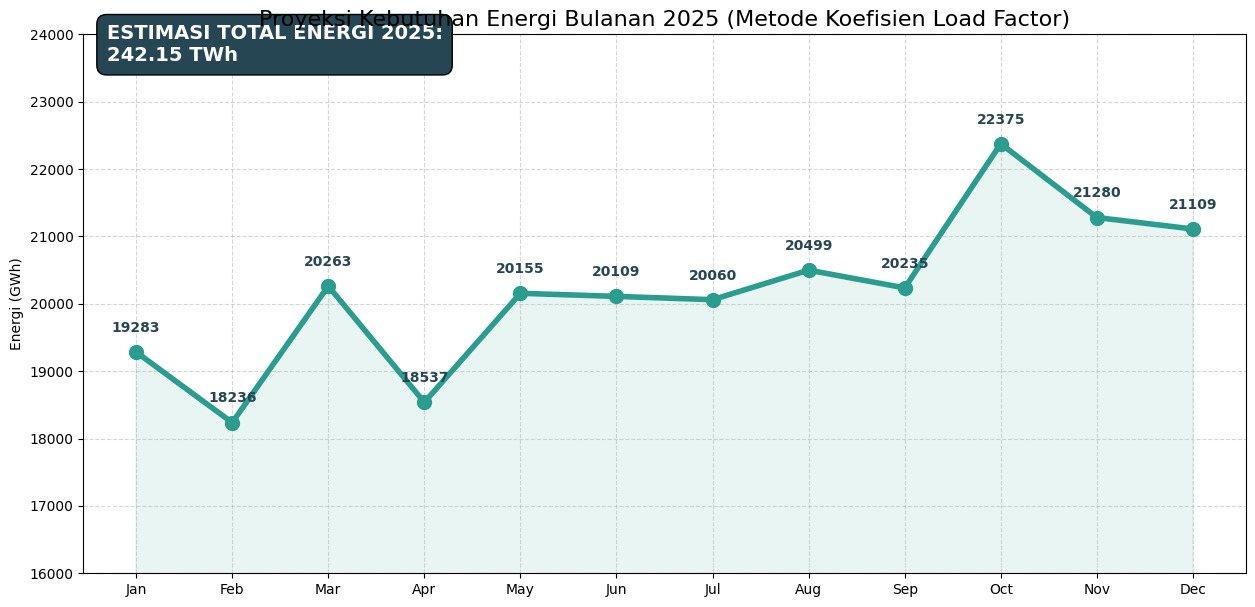

   Bulan  Peak 2025 (MW)  Koefisien LF  Energi 2025 (GWh)
0    Jan           30993        0.8363              19284
1    Feb           32334        0.8393              18237
2    Mar           32376        0.8412              20263
3    Apr           32630        0.7891              18538
4    May           32798        0.8260              20155
5    Jun           33155        0.8424              20110
6    Jul           31781        0.8484              20061
7    Aug           32177        0.8563              20499
8    Sep           33083        0.8495              20235
9    Oct           35216        0.8540              22375
10   Nov           34775        0.8499              21280
11   Dec           34158        0.8307              21110

TOTAL KEBUTUHAN ENERGI TAHUN 2025: 242.15 TWh


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

# 1. LOAD DATA & CLEANING
df = pd.read_csv('Load_Forecasting.csv')
time_cols = df.columns[2:50]
for col in time_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[time_cols] = df[time_cols].ffill(axis=1).bfill(axis=1)

df['Tanggal_dt'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
df['Year'] = df['Tanggal_dt'].dt.year
df['Month'] = df['Tanggal_dt'].dt.month

# 2. HITUNG KOEFISIEN LOAD FACTOR (LF) HISTORIS (2022, 2023, 2024)
monthly_coeffs = []

for y in [2022, 2023, 2024]:
    for m in range(1, 13):
        m_data = df[(df['Year'] == y) & (df['Month'] == m)]
        if not m_data.empty:
            peak = m_data[time_cols].max().max()
            energy_mwh = (m_data[time_cols].sum(axis=1) * 0.5).sum()
            
            # Jam kalender asli
            days_in_month = calendar.monthrange(y, m)[1]
            total_hours = days_in_month * 24
            
            # HITUNG KOEFISIEN LF
            lf_coeff = energy_mwh / (peak * total_hours)
            monthly_coeffs.append({'Month': m, 'LF': lf_coeff})

df_coeffs = pd.DataFrame(monthly_coeffs)
avg_monthly_lf = df_coeffs.groupby('Month')['LF'].mean()

# 3. DATA INPUT PEAK 2025 (Hasil model Dynamic Trend sebelumnya)
peak_2025 = [30993, 32334, 32376, 32630, 32798, 33155, 31781, 32177, 33083, 35216, 34775, 34158]

# 4. HITUNG ENERGI 2025 MENGGUNAKAN KOEFISIEN LF
forecast_energy_2025 = []
for i in range(12):
    m = i + 1
    days_2025 = calendar.monthrange(2025, m)[1]
    hours_2025 = days_2025 * 24
    
    # Rumus: Peak * Koefisien LF * Jam
    energy_val = peak_2025[i] * avg_monthly_lf[m] * hours_2025
    forecast_energy_2025.append(energy_val / 1000) # Convert ke GWh

total_energy_2025_twh = sum(forecast_energy_2025) / 1000

# 5. VISUALISASI LINE CHART
months_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(15, 7))
plt.plot(months_names, forecast_energy_2025, marker='o', color='#2a9d8f', linewidth=4, markersize=10, label='Proyeksi Energi 2025')
plt.fill_between(months_names, forecast_energy_2025, color='#2a9d8f', alpha=0.1)

# Tambahkan Label Angka
for i, v in enumerate(forecast_energy_2025):
    plt.text(i, v + 300, f'{int(v)}', ha='center', fontweight='bold', color='#264653')

# Info Box Total Energi
plt.gca().text(0.02, 0.95, f"ESTIMASI TOTAL ENERGI 2025:\n{total_energy_2025_twh:.2f} TWh", 
               transform=plt.gca().transAxes, fontsize=14, fontweight='bold', 
               color='white', bbox=dict(boxstyle='round', facecolor='#264653', pad=0.5))

plt.title('Proyeksi Kebutuhan Energi Bulanan 2025 (Metode Koefisien Load Factor)', fontsize=16)
plt.ylabel('Energi (GWh)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(16000, 24000)
plt.show()

# 6. TABEL HASIL UNTUK REPORT
report = pd.DataFrame({
    'Bulan': months_names,
    'Peak 2025 (MW)': peak_2025,
    'Koefisien LF': avg_monthly_lf.values.round(4),
    'Energi 2025 (GWh)': np.round(forecast_energy_2025, 0).astype(int)
})
print(report)
print(f"\nTOTAL KEBUTUHAN ENERGI TAHUN 2025: {total_energy_2025_twh:.2f} TWh")